In [51]:
import importlib
importlib.reload(RTPython)

<module 'RTPython' from '/home/user/u0133590/git/rtpython/RTPython/__init__.py'>

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.animation as animation
%matplotlib notebook

# Single particle (RTP)
---

In [37]:
rtp_ang0 = 0
rtp_v0 = np.array((np.cos(rtp_ang0), np.sin(rtp_ang0)))
rtp_r0 = np.array((0, 0))
rtp_t0 = 0.1
rtp_a = 0.1 # tumble rate
rtp_v = 1 # run velocity

rtp = {'v':rtp_v0, 'r':rtp_r0, 't':rtp_t0, 'a':rtp_a, 'v0':rtp_v}

def srkstep(dt, rtp):
    r0 = rtp['r']
    v0 = rtp['v']
    if rtp['t'] < dt:
        ang_new = 2*np.pi*np.random.random()
        v1 = np.array((np.cos(ang_new), np.sin(ang_new)))
        rtp['t'] = np.random.exponential(1/rtp_a)
    else:
        v1 = v0
        rtp['t'] = rtp['t'] - dt
    rtp['v'] = v1
    rtp['r'] = r0 + 0.5 * (v0 + v1) * dt

In [38]:
path = np.zeros((10000, 2))
for i in range(10000):
    path[i] = rtp['r']
    srkstep(0.1, rtp)

<IPython.core.display.Javascript object>


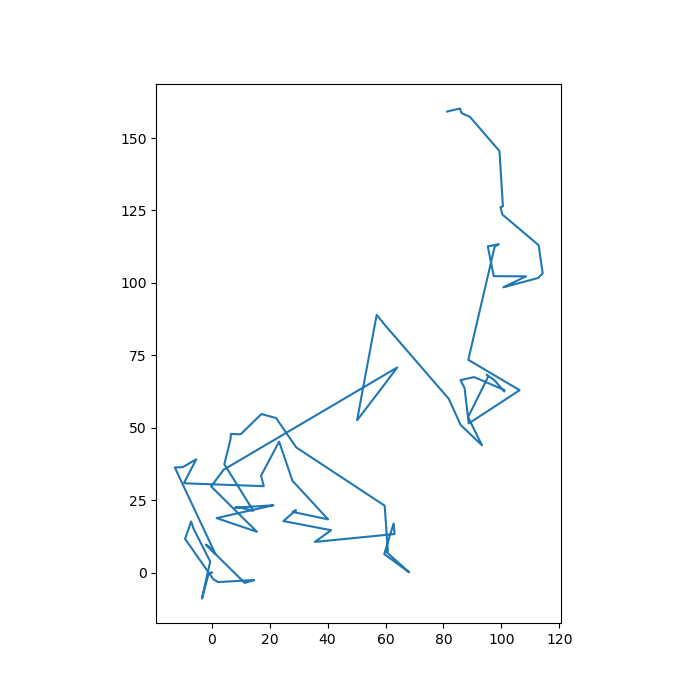

In [40]:
plt.figure(figsize=(7,7))

plt.gca().set_aspect('equal')

plt.plot(*path.T)

# Many particles (vectorized)
---

In [81]:
N_rtp = 100
L = 10

rtp_a = 1 # tumble rate
rtp_v = 1 # run velocity

rtp_ang0 = 2*np.pi*np.random.random(N_rtp)
rtp_v0 = np.array((np.cos(rtp_ang0), np.sin(rtp_ang0))).T
rtp_r0 = L * np.random.random((N_rtp,2))
rtp_t0 = np.random.exponential(1/rtp_a, N_rtp)


rtp = {'v':rtp_v0, 'r':rtp_r0, 't':rtp_t0, 'a':rtp_a, 'v0':rtp_v}

def srkstep(dt, rtp):
    r0 = rtp['r']
    v0 = rtp['v']
    
    tumbles = np.where(rtp['t'] < dt)
    ang_new = 2*np.pi*np.random.random(N_t:=len(tumbles[0]))
    v1 = v0
    v1[tumbles] = np.array((np.cos(ang_new), np.sin(ang_new))).T
    
    rtp['t'] -= dt
    rtp['t'][tumbles] = np.random.exponential(1/rtp_a, N_t)
    
    rtp['v'] = v1
    rtp['r'] = r0 + 0.5 * (v0 + v1) * dt

In [82]:
path = np.zeros((10000, 100, 2))
for i in range(10000):
    path[i] = rtp['r']
    srkstep(0.01, rtp)

<IPython.core.display.Javascript object>


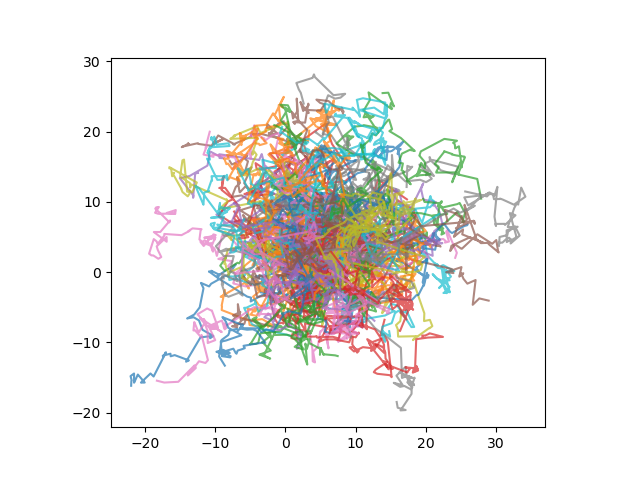

In [83]:
plt.figure()

plt.gca().set_aspect('equal')

plt.plot(path[:,:,0], path[:,:,1], alpha=0.7);

# Interacting particles
---
with pbc

In [3]:
import RTPython as rtpy

Frep = rtpy.forces.wca

rtp_int = rtpy.md.interaction_periodic

In [39]:
L = 200

rtp_rate = 0.01 # tumble rate
rtp_v = 1 # run velocity
rtp_a = 1 # rtp diameter == interaction range

rtp_r0 = rtpy.initialize.simple_grid(L, 0.35, rtp_a)
rtp_ang0 = 2 * np.pi * np.random.random(N_rtp:=len(rtp_r0))
rtp_v0 = rtp_v * np.array((np.cos(rtp_ang0), np.sin(rtp_ang0))).T
rtp_t0 = np.random.exponential(1/rtp_rate, N_rtp)


rtp = {'v':rtp_v0, 'r':rtp_r0, 't':rtp_t0, 'rate':rtp_rate, 'v0':rtp_v, 'a':rtp_a, 'time':0.0, 'type':'rtp'}

# force, cutoff, boxsize, eps, a
int_args = [Frep, 2**(1/6)*rtp['a'], L, 1, rtp['a']]

def srkstep(dt, rtp, interactions):
    r0 = rtp['r']
    v0 = rtp['v']
    
    F1 = interactions(r0, *int_args)
    
    # Decrease time step size if necessary; dt is the *maximum* timestep
    dtr = min(dt, 0.05/(np.max(F1) + rtp['v0']))
    
    # Handle tumbles
    tumbles = np.where(rtp['t'] < dtr)
    
    N_t = len(tumbles[0])
    ang_new = 2*np.pi*np.random.random(N_t)
    v1 = v0
    v1[tumbles] = rtp['v0'] * np.array((np.cos(ang_new), np.sin(ang_new))).T
    
    rtp['t'] -= dt
    rtp['t'][tumbles] = np.random.exponential(1/rtp['rate'], N_t)
    
    # Evaluate forces
    F2 = interactions((r0 + (v0 + F1) * dtr) % L, *int_args)
    
    rtp['r'] = (r0 + 0.5*(v0 + v1 + F1 + F2)*dtr) % L
    
    return dtr

In [41]:
N_steps = 5000000
rate = 500

path = np.zeros((N_steps//rate, N_rtp, 2))

for i in range(N_steps//rate):
    path[i] = rtp['r']
    for _ in range(rate):
        dt = srkstep(0.001, rtp, rtp_int)
        rtp['time'] += dt
        print(f'{rtp["time"]:.4f}, {dt:.4f}', end='\r')

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


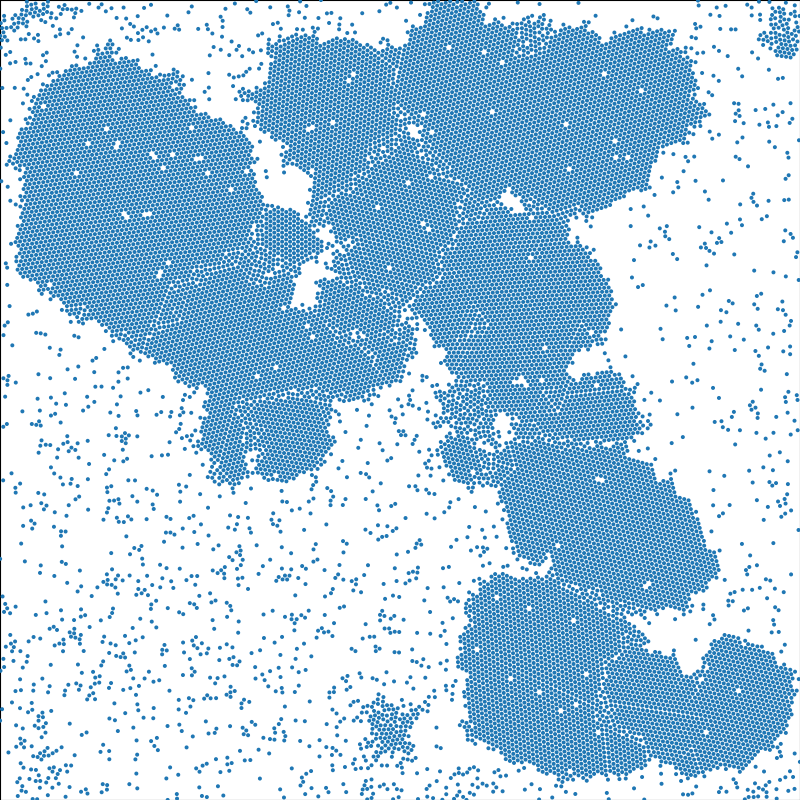

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

dx = 82
dy = 8

for x, y in rtp['r']:
    circle = Circle(xy=((x+dx)%L,(y+dy)%L), radius=rtp['a']/2, zorder=5)
    ax.add_patch(circle)
    
ax.set_xlim(0,L)
ax.set_ylim(0,L)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

<IPython.core.display.Javascript object>


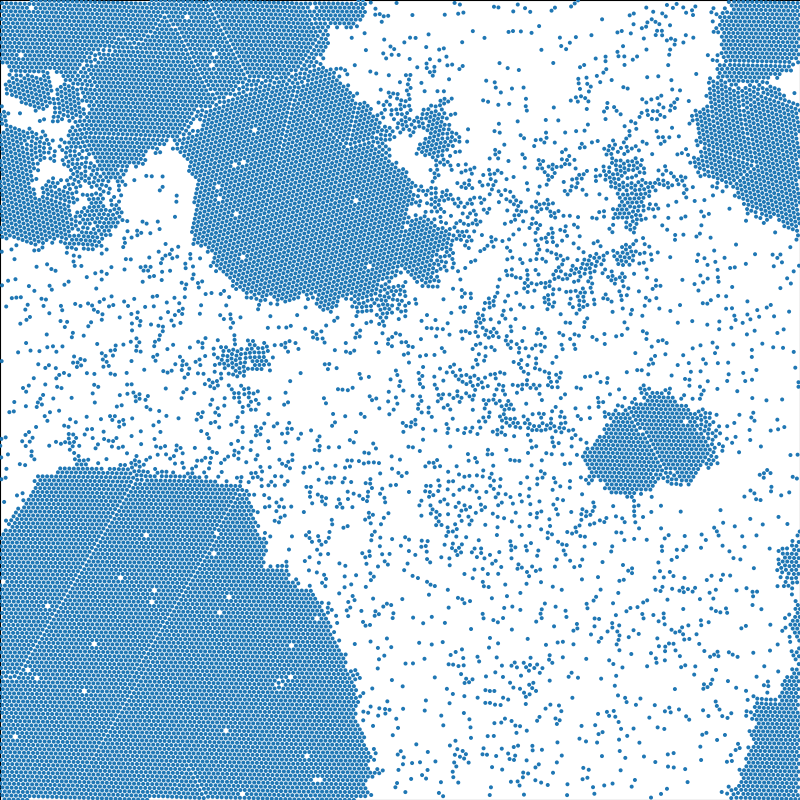

In [40]:
### Generate animation with correct circle sizes (slow) ###
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

plt.xlim(0,L)
plt.ylim(0,L)
plt.xticks([])
plt.yticks([])

# list rtps is a list of all the circle objects representing the RTPs
rtps = []
for x, y in path[0]:
    circle = Circle(xy=(x,y), radius=rtp['a']/2, zorder=5)
    ax.add_patch(circle)
    rtps.append(circle)
    
# update RTP positions
def update(i):
    for j in range(N_rtp):
        rtps[j].center = (path[i+1,j,:])
    return rtps
        
ani = animation.FuncAnimation(fig, update, save_count=N_steps//rate-1, interval=10, blit=True);

# Save animation as mp4
# ani.save('srk_variable_dt.mp4', writer='ffmpeg', fps=60, dpi=200, progress_callback=lambda i, n: print(f'Saving frame {i+1} of {n}', end='\r'));

<IPython.core.display.Javascript object>


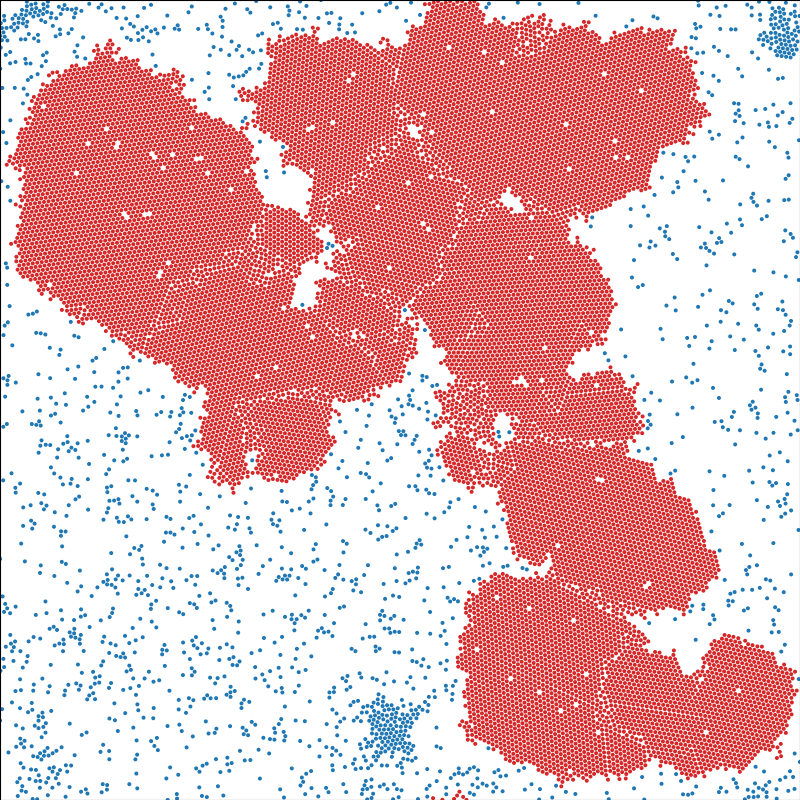

In [47]:
import RTPython.clusters

r = rtp['r']
clusters = rtpy.clusters.get_clusters(r, 1.1, L)

fig, ax = plt.subplots(figsize=(8,8))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

dx = 82
dy = 8

for clust in clusters:
    rc = r[clust]
    if len(rc)/N_rtp > 0.1:
        color = 'C3'
    else:
        color = 'C0'
    for x, y in rc:
        circle = Circle(xy=((x+dx)%L,(y+dy)%L), radius=.5)
        circle.set_fc(color)
        ax.add_patch(circle)
    
ax.set_xlim(0,L)
ax.set_ylim(0,L)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

In [48]:
rtpy.clusters.largest_cluster_size(clusters)/N_rtp

0.8927349228611501

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [55]:
fc = []
for i, r in enumerate(path[:5000]):
    print(i, end='\r')
    clusters = rtpy.clusters.get_clusters(r, 1.1, L)
    fc.append(rtpy.clusters.largest_cluster_size(clusters)/N_rtp)

<IPython.core.display.Javascript object>


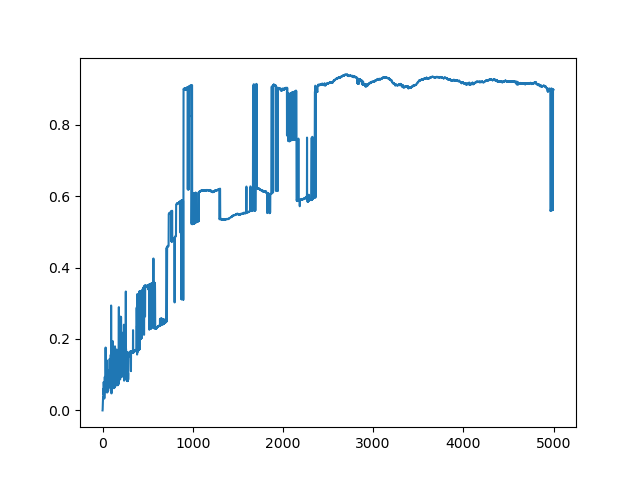

In [58]:
plt.figure()
plt.plot(fc)